In [4]:
#------------------------ Header Comment ----------------------#
# File: preprocessing.ipynb
# Date: 2024-11-03
# Author: Weizhi Peng
#--------------------------------------------------------------#
# Purpose:
# This notebook is designed to implement a comprehensive data-centric 
# approach for EEG-based emotion recognition using the SEED-IV dataset. 
# It covers exploratory data analysis (EDA), data validation and 
# cleaning, data augmentation, and dataset curation, including the 
# creation of training, validation, and test sets for robust 
# model evaluation.
#
# Main steps of the pipeline:
# 1. Load and inspect the SEED-IV dataset using TorchEEG.
# 2. Perform exploratory data analysis to understand data distribution 
#    and detect potential biases.
# 3. Preprocess and clean the data to ensure consistency.
# 4. Apply data augmentation techniques for better generalization.
# 5. Split the data into training, validation, and test sets using 
#    10-fold cross-validation.
#
# Requirements:
# - Python (3.7+)
# - NumPy
# - Pandas
# - PyTorch
# - TorchEEG
# - Matplotlib
# - Seaborn
# - Scikit-learn
#
# Notes:
# The notebook is designed to work with GPU acceleration if available 
# (CUDA or MPS), and will default to using CPU if neither is accessible.
#--------------------------------------------------------------#


# load raw dataset
from torcheeg import transforms
from torcheeg.datasets import SEEDIVDataset
from torcheeg.datasets.constants.emotion_recognition.seed_iv import (SEED_IV_ADJACENCY_MATRIX,
                                                   SEED_IV_CHANNEL_LOCATION_DICT
                                                   )

# load raw dataset
dataset = SEEDIVDataset(root_path='../../data/SEED_IV/eeg_raw_data',
                io_path='.torcheeg/datasets_1730661358322_GoAUP',
                online_transform=transforms.ToTensor(),
                label_transform=transforms.Compose([
                    transforms.Select('emotion'),
                    transforms.Lambda(lambda x: x),
                ]),
                num_worker=4)

(sample,target) = dataset[0]
print("shape of input sample",sample.shape)
# check how many target classes from dataset
target_list = []
for i in range(len(dataset)):
    _, target = dataset[i]
    target_list.append(target)
print("target_list",set(target_list))
print("length of dataset",len(dataset))


[2024-11-03 15:08:22] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from .torcheeg/datasets_1730661358322_GoAUP.


shape of input sample torch.Size([62, 800])
target_list {0, 1, 2, 3}
length of dataset 37575


In [2]:
print("SEED IV channel length",len(SEED_IV_CHANNEL_LOCATION_DICT))

SEED IV channel length 62


Total number of samples: 37575


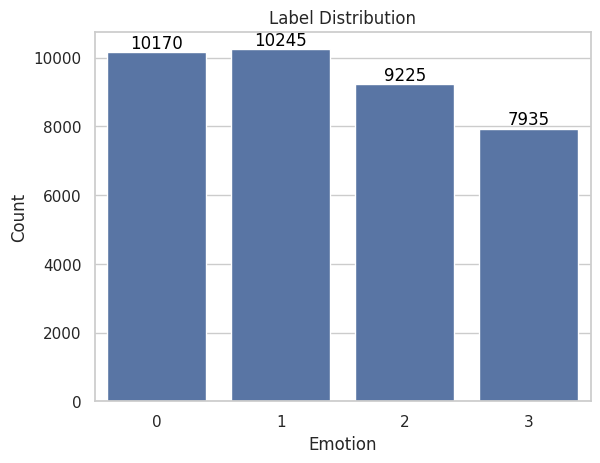

In [12]:
# label data distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Check the basic structure of the dataset
print(f"Total number of samples: {len(dataset)}")

# Analyze label distribution
labels = [dataset[i][1] for i in range(len(dataset))] 

# Create the count plot
sns.set(style="whitegrid")
ax = sns.countplot(x=labels)

# Add counts on top of each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black')

plt.title("Label Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()



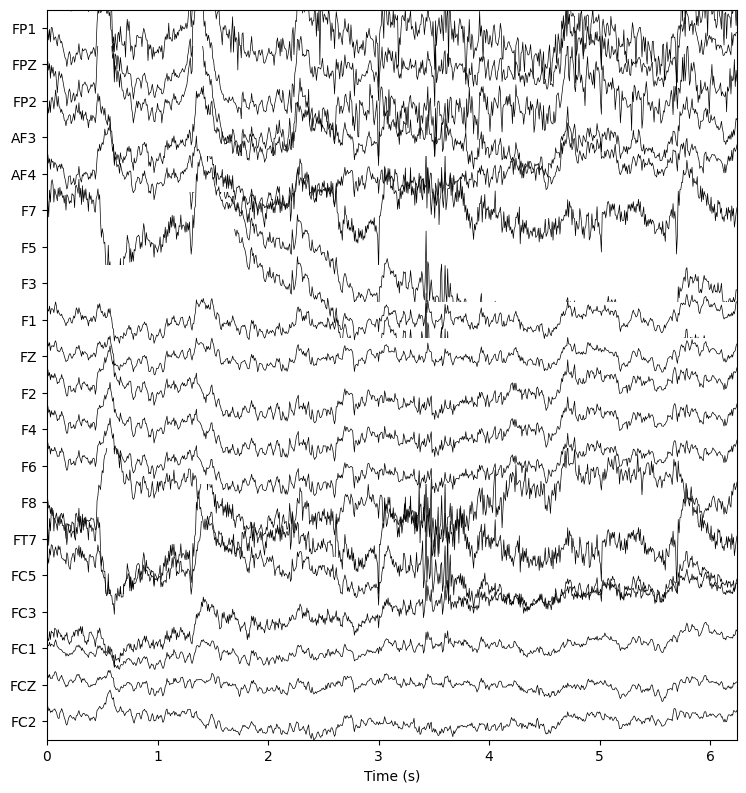

In [8]:
# plot_signal
from torcheeg.utils import plot_signal
from torcheeg.datasets.constants.emotion_recognition.seed_iv import SEED_IV_CHANNEL_LIST

eeg = sample
img = plot_signal(eeg,channel_list=SEED_IV_CHANNEL_LIST,sampling_rate=128)

/home/jim/anaconda3/envs/eeg/lib/python3.9/site-packages/mne/viz/circle.py:267: RuntimeWarning: invalid value encountered in divide
  con_val_scaled = (con - vmin) / vrange


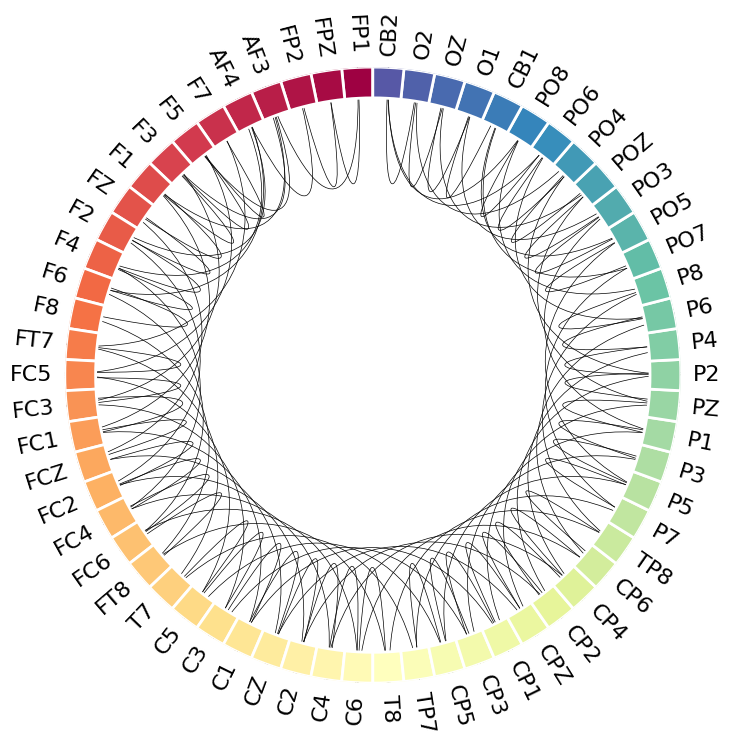

In [3]:
# plot_adj_connectivity graph
from torcheeg.utils import plot_adj_connectivity
from torcheeg.datasets.constants.emotion_recognition.seed_iv import SEED_IV_CHANNEL_LIST, SEED_IV_ADJACENCY_LIST
import numpy as np
import torch

# List of all electrode names
electrode_list = list(SEED_IV_ADJACENCY_LIST.keys())

# Create an empty 62x62 matrix
adjacency_matrix = np.zeros((62, 62), dtype=int)

# Fill the adjacency matrix
for i, electrode in enumerate(electrode_list):
    for neighbor in SEED_IV_ADJACENCY_LIST[electrode]:
        j = electrode_list.index(neighbor)
        adjacency_matrix[i, j] = 1  # Set the matrix value to 1 if connected

# Convert the adjacency matrix to a PyTorch tensor
adjacency_matrix_tensor = torch.tensor(adjacency_matrix)

# Plot the adjacency connectivity
img = plot_adj_connectivity(adjacency_matrix_tensor, SEED_IV_CHANNEL_LIST,linewidth=0.5)


filtered_sample torch.Size([60, 800])


/home/jim/anaconda3/envs/eeg/lib/python3.9/site-packages/mne/viz/topomap.py:976: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cont.collections:
/home/jim/anaconda3/envs/eeg/lib/python3.9/site-packages/mne/viz/topomap.py:976: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cont.collections:
/home/jim/anaconda3/envs/eeg/lib/python3.9/site-packages/mne/viz/topomap.py:976: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cont.collections:
/home/jim/anaconda3/envs/eeg/lib/python3.9/site-packages/mne/viz/topomap.py:976: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cont.collections:


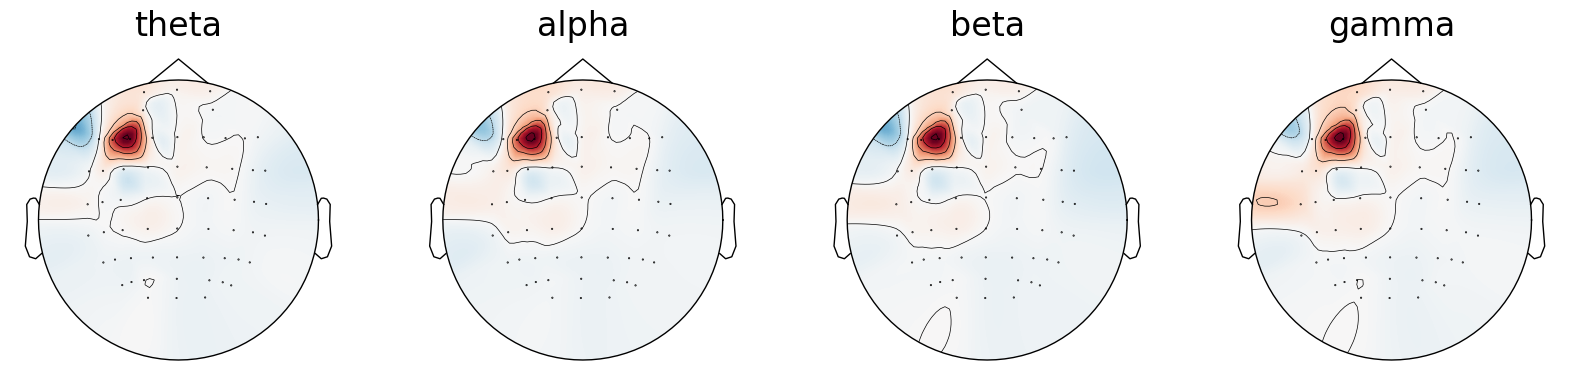

In [10]:
# Plot a topographic map of the the raw sample EEG signal

from torcheeg.utils import plot_feature_topomap
from torcheeg.datasets.constants.emotion_recognition.seed_iv import SEED_IV_CHANNEL_LIST
# Filter out problematic electrodes
filtered_channel_list = [ch for ch in SEED_IV_CHANNEL_LIST if ch not in ['CB1', 'CB2']]
# remove the last channel
filtered_sample = sample[:-1,:]
# remove the sample at -4 row
filtered_sample = torch.cat((filtered_sample[:-4,:],filtered_sample[-3:,:]),0)
print("filtered_sample",filtered_sample.shape)
eeg = filtered_sample
img = plot_feature_topomap(eeg,channel_list=filtered_channel_list,feature_list=["theta", "alpha", "beta", "gamma"])

filtered_sample torch.Size([60, 800])


/home/jim/anaconda3/envs/eeg/lib/python3.9/site-packages/mne/viz/topomap.py:976: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cont.collections:
/home/jim/anaconda3/envs/eeg/lib/python3.9/site-packages/mne/viz/topomap.py:976: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cont.collections:
/home/jim/anaconda3/envs/eeg/lib/python3.9/site-packages/mne/viz/topomap.py:976: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cont.collections:
/home/jim/anaconda3/envs/eeg/lib/python3.9/site-packages/mne/viz/topomap.py:976: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cont.collections:


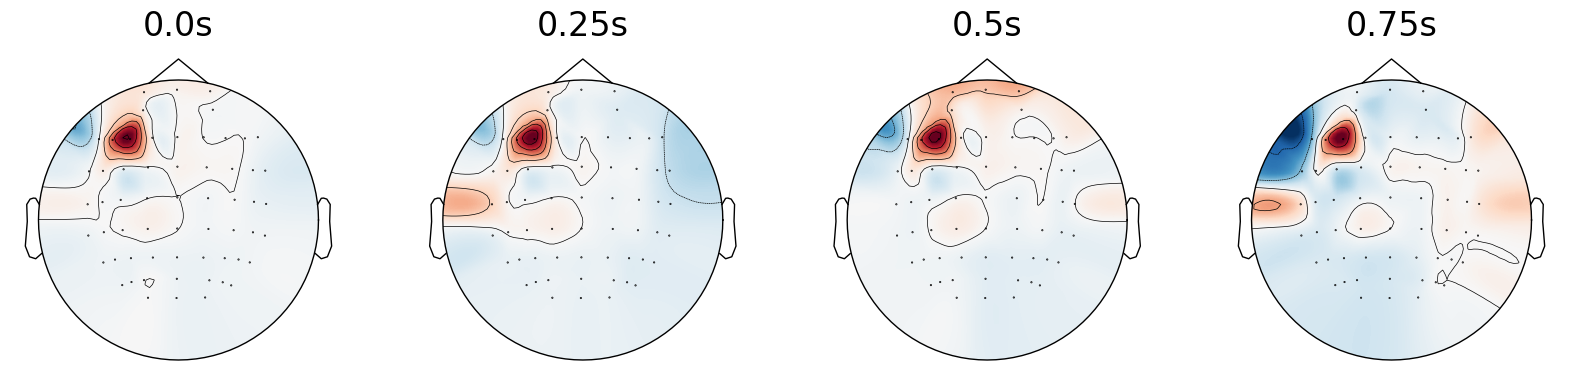

In [11]:
# Plot a topographic map of the raw sample EEG signal
from torcheeg.utils import plot_raw_topomap
from torcheeg.datasets.constants.emotion_recognition.seed_iv import SEED_IV_CHANNEL_LIST
# Filter out problematic electrodes
filtered_channel_list = [ch for ch in SEED_IV_CHANNEL_LIST if ch not in ['CB1', 'CB2']]
# remove the last channel CB2 channel
filtered_sample = sample[:-1,:]
# remove the sample at -4 row CB1 channel
filtered_sample = torch.cat((filtered_sample[:-4,:],filtered_sample[-3:,:]),0)
print("filtered_sample",filtered_sample.shape)
eeg = filtered_sample
img = plot_raw_topomap(eeg,
                 channel_list=filtered_channel_list,
                 sampling_rate=128)

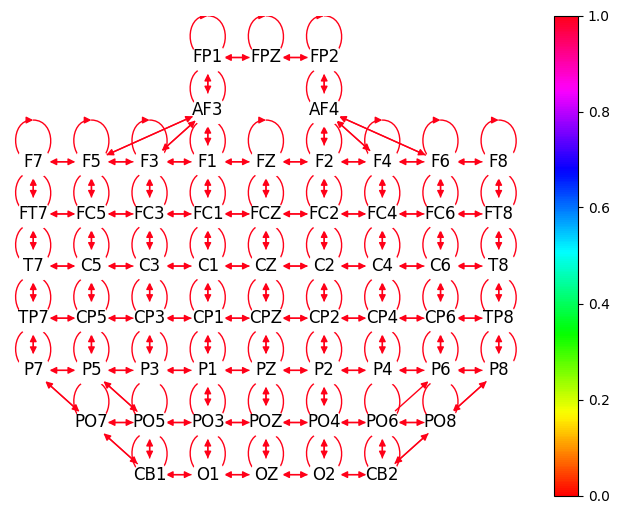

In [13]:
# Visualize a graph structure of each EEG feature
from torcheeg.utils.pyg import plot_graph
from torcheeg.datasets.constants import DEAP_CHANNEL_LOCATION_DICT
from torcheeg.datasets.constants.emotion_recognition.seed_iv import (SEED_IV_ADJACENCY_MATRIX,
                                                   SEED_IV_CHANNEL_LOCATION_DICT)
from torcheeg.datasets.constants.emotion_recognition.seed_iv import SEED_IV_CHANNEL_LIST

from torcheeg.transforms.pyg import ToG
import numpy as np

eeg = sample
g = ToG(SEED_IV_ADJACENCY_MATRIX)(eeg=eeg)['eeg']
img = plot_graph(g,SEED_IV_CHANNEL_LOCATION_DICT)

In [13]:
# Iterate over dataset to check for missing or NaN values
for i in range(len(dataset)):
    data, label = dataset[i]
    if torch.isnan(data).any():
        print(f"NaN found in data at index {i}")
    if label is None:
        print(f"Missing label at index {i}")

In [ ]:
# Apply normalization if needed
from torcheeg import transforms

dataset = SEEDIVDataset(
    root_path='../data/SEED_IV/eeg_raw_data',
    offline_transform=transforms.Compose([
        transforms.BandDifferentialEntropy(),
        transforms.ToGrid(SEED_IV_CHANNEL_LOCATION_DICT),
        transforms.MinMaxNormalize()  # Add normalization transform
    ]),
    online_transform=transforms.ToTensor(),
    label_transform=transforms.Compose([
        transforms.Select('emotion'),
        transforms.Lambda(lambda x: x),
    ]),
    num_worker=4
)

In [ ]:
# Data Augmentation using RandomNoise and RandomMasking

from torcheeg import transforms

augmented_dataset = SEEDIVDataset(
    root_path='../data/SEED_IV/eeg_raw_data',
    offline_transform=transforms.Compose([
        transforms.BandDifferentialEntropy(),
        transforms.ToGrid(SEED_IV_CHANNEL_LOCATION_DICT),
        transforms.RandomNoise(),  # Add Gaussian noise for augmentation
        transforms.RandomMasking()  # Randomly mask parts of the EEG signal
    ]),
    online_transform=transforms.ToTensor(),
    label_transform=transforms.Compose([
        transforms.Select('emotion'),
        transforms.Lambda(lambda x: x),
    ]),
    num_worker=4
)

[2024-11-03 14:59:47] INFO (torcheeg/MainThread) 📊 | Detected existing split of train and test set, use existing split from ./.tmp_out/examples_pipeline/split.
[2024-11-03 14:59:47] INFO (torcheeg/MainThread) 💡 | If the dataset is re-generated, you need to re-generate the split of the dataset instead of using the previous split.


Fold 1


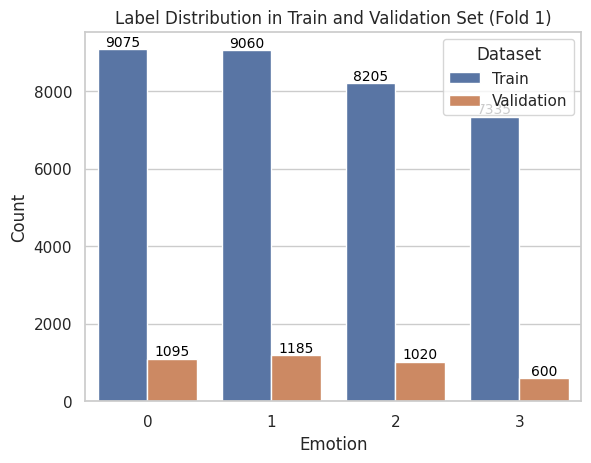

In [18]:
# Dataset Curation and Analysis of Bias

from torcheeg.model_selection import KFoldGroupbyTrial
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_split_distribution(train_dataset, val_dataset, fold_number):
    train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
    val_labels = [val_dataset[i][1] for i in range(len(val_dataset))]

    # Combine the labels into a single DataFrame for seaborn
    train_df = pd.DataFrame({'Label': train_labels, 'Set': 'Train'})
    val_df = pd.DataFrame({'Label': val_labels, 'Set': 'Validation'})
    combined_df = pd.concat([train_df, val_df])

    ax = sns.countplot(x='Label', hue='Set', data=combined_df)
    plt.title(f"Label Distribution in Train and Validation Set (Fold {fold_number})")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.legend(title="Dataset")

    # Add counts on top of each bar
    for p in ax.patches:
        count = int(p.get_height())
        if count > 0:  # Only annotate if the count is greater than 0
            ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=10, color='black')

    plt.show()

# 10-fold cross-validation
k_fold = KFoldGroupbyTrial(n_splits=10,
                           split_path='./.tmp_out/examples_pipeline/split',
                           shuffle=True,
                           random_state=42)

# Analysis of Bias of train and test set
for i, (train_dataset, val_dataset) in enumerate(k_fold.split(dataset)):
    print(f"Fold {i + 1}")
    plot_split_distribution(train_dataset, val_dataset, fold_number=i + 1)
    break
